In [1]:
import numpy as np
import pandas as pd
import tensorflow as tg
import random
from collections import deque
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_style("whitegrid")

In [3]:
SEQ_LEN = 60
FUTURE_PERIOD_PREDICT = 1
RATIO_TO_PREDICT = "mid"

In [4]:
def classify(current, future):
    if float(future)>float(current):
        return 1
    else:
        return 0
    
def preprocessing_df(df):
    pass

In [5]:
df = pd.read_csv("NSE.csv")
df.drop(columns={"Adj Close"}, inplace=True)
df['Date']= pd.to_datetime(df['Date']) 
df.sort_values(by='Date', inplace=True)

In [6]:
df.info() 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2860 entries, 0 to 2859
Data columns (total 6 columns):
Date      2860 non-null datetime64[ns]
Open      2834 non-null float64
High      2834 non-null float64
Low       2834 non-null float64
Close     2834 non-null float64
Volume    2834 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 156.4 KB


In [7]:
df.dropna(inplace=True)
df['mid'] = df['Low'] + (df['High']-df['Low'])/2
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))

In [8]:
df.tail(3)

,Date,Open,High,Low,Close,Volume,mid,future,target
2857,2019-04-15,11667.000000,11704.599609,11648.250000,11690.349609,281300.0,11676.424805,11771.250000,1
2858,2019-04-16,11736.200195,11810.950195,11731.549805,11787.150391,343700.0,11771.250000,11797.325195,1
2859,2019-04-18,11856.150391,11856.150391,11738.500000,11752.799805,329500.0,11797.325195,NaN,0


In [9]:
df.drop(columns={"Date","Open","High","Low","Close","Volume","future"}, inplace=True)

In [10]:
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(len(times)*0.1)]
last_20pct = sorted(df.index.values)[-int(len(times)*0.2)]
print('Last 10%: {} \nLast 20%: {}'.format(last_10pct, last_20pct))

Last 10%: 2576 
Last 20%: 2292


In [11]:
test_df = df[(df.index >= last_10pct)]
validation_df = df[(df.index >= last_20pct) & (df.index < last_10pct)]
train_df = df[(df.index < last_20pct)]

In [12]:
validation_df.head()

,mid,target
2292,8155.875000,1
2293,8172.899902,1
2294,8183.849854,1
2295,8199.699951,1
2296,8253.175293,1


In [13]:
test_data = test_df[RATIO_TO_PREDICT].as_matrix()
validation_data = validation_df[RATIO_TO_PREDICT].as_matrix()
train_data = train_df[RATIO_TO_PREDICT].as_matrix()

train_data = train_data.reshape(-1,1)
validation_data = validation_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

/home/abhishek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/abhishek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/abhishek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)

In [15]:
train_data = train_data.reshape(-1)
validation_data = scaler.transform(validation_data).reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)

In [16]:
EMA = 0.0
beta = 0.01
for i in range(len(train_data)):
    EMA = beta*train_data[i] + (1-beta)*EMA
    train_data[i] = EMA

all_mid_data = np.concatenate([train_data,validation_data, test_data],axis=0)

In [17]:
X_train = []
y_train = []
for i in range(SEQ_LEN, len(train_data)):
    X_train.append(train_data[i-SEQ_LEN:i])
    y_train.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [18]:
X_valid = []
y_valid = []
for i in range(SEQ_LEN, len(validation_data)):
    X_valid.append(validation_data[i-SEQ_LEN:i])
    y_valid.append(validation_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [19]:
X_test = []
y_test = []
for i in range(SEQ_LEN, len(test_data)):
    X_test.append(test_data[i-SEQ_LEN:i])
    y_test.append(test_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [20]:
print('y train shape: {} \ny valid shape: {} \ny test shape: {}'.format(y_train.shape, y_valid.shape, y_test.shape))

y train shape: (2208,) 
y valid shape: (223,) 
y test shape: (223,)


In [21]:
X_train_2 = []
y_train_2 = []
for i in range(SEQ_LEN, len(train_data)):
    X_train_2.append(train_data[i-SEQ_LEN:i])
    y_train_2.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train_2, y_train_2 = np.array(X_train_2), np.array(y_train_2)

X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 1))

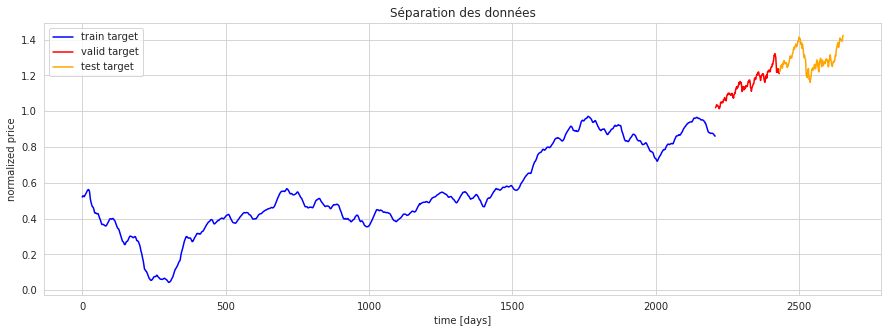

In [22]:
## show predictions
plt.figure(figsize=(15, 5))
plt.plot(np.arange(y_train_2.shape[0]), y_train_2, color='blue', label='train target')
plt.plot(np.arange(y_train_2.shape[0], y_train_2.shape[0]+y_valid.shape[0]), y_valid, color='red', label='valid target')
plt.plot(np.arange(y_train_2.shape[0]+y_valid.shape[0], y_train_2.shape[0]+y_valid.shape[0]+y_test.shape[0]), y_test, color='orange', label='test target')
plt.title('Séparation des données')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

# MODEL

In [66]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

import time
EPOCHS = 10
BATCH_SIZE = 64
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [67]:
y_train = np.reshape(y_train, (-1, 1))
y_valid = np.reshape(y_valid, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

In [68]:
y_test.shape

(223, 1)

In [26]:
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense,LSTM,Dropout,BatchNormalization
#from tensorflow.keras.callbacks import ModelCheckpoint

In [69]:
!pip install -q tensorflow==2.0.0-alpha0

In [70]:
# https://www.kaggle.com/shujian/transformer-with-lstm

import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.python.keras.layers import Layer
from keras import backend as K

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(1, activation="sigmoid")(conc)   
        
        
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [94]:
def build_model():
    inp = Input(shape = (SEQ_LEN, 1))
    
    # LSTM before attention layers
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    #x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
    #avg_pool = GlobalAveragePooling1D()(x)
    #max_pool = GlobalMaxPooling1D()(x)
    #conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(x)
    conc = Dense(64, activation="relu")(conc)
    x = Dense(1, activation="sigmoid")(conc)      

    model = Model(inputs = inp, outputs = x)
    model.compile(
        loss = "mean_squared_error", 
        #optimizer = Adam(lr = config["lr"], decay = config["lr_d"]), 
        optimizer = "adam")
    
    # Save entire model to a HDF5 file
    #model.save('my_model.h5')
    
    return model

In [95]:
multi_head = build_model()

In [96]:
multi_head.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 60, 1)]           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 60, 256)           133120    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 60, 128)           164352    
_________________________________________________________________
dense_27 (Dense)             (None, 60, 64)            8256      
_________________________________________________________________
dense_28 (Dense)             (None, 60, 64)            4160      
_________________________________________________________________
dense_29 (Dense)             (None, 60, 1)             65        
Total params: 309,953
Trainable params: 309,953
Non-trainable params: 0
_____________________________________________________

In [97]:
multi_head.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid), 
                    #callbacks = [checkpoint , lr_reduce]
             )

ValueError: A target array with shape (2208, 1) was passed for an output of shape (None, 60, 1) while using as loss `mean_squared_error`. This loss expects targets to have the same shape as the output.

In [75]:
prediction = multi_head.predict(X_test)
prediction.shape

(223, 1)

In [76]:
prediction = np.vstack((np.full((60,1), np.nan), prediction))


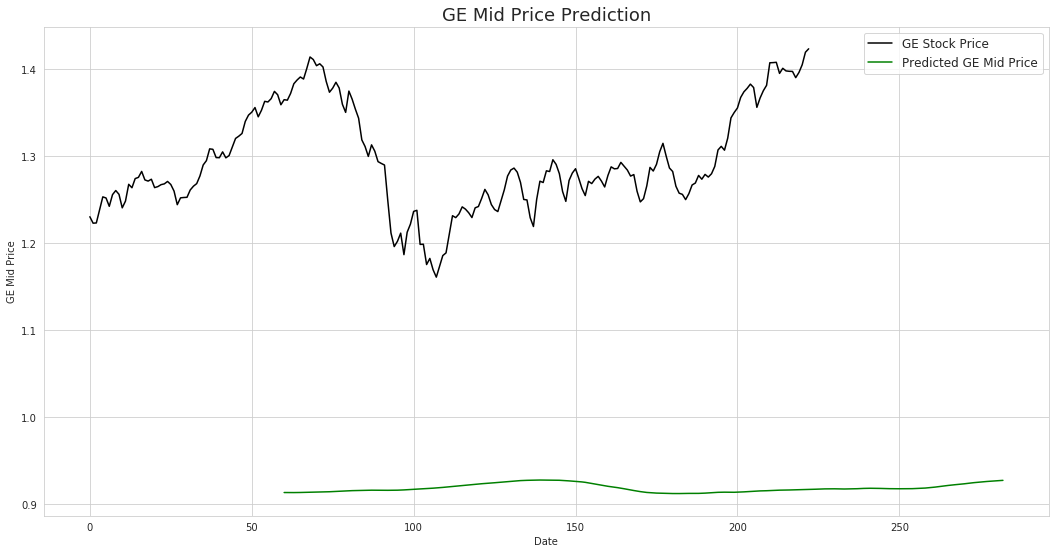

In [80]:
plt.figure(figsize = (18,9))
plt.plot(y_test, color = 'black', label = 'GE Stock Price')
plt.plot(prediction, color = 'green', label = 'Predicted GE Mid Price')
plt.title('GE Mid Price Prediction', fontsize=18)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('GE Mid Price')
plt.legend(fontsize=12)
plt.show()

In [58]:
pred = prediction
pred2 = np.multiply(pred,1.6)

In [86]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQ_LEN, 1), activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [87]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(loss='mean_squared_error',
             optimizer=opt,
             metrics=['accuracy'])

In [88]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_10 (UnifiedLSTM (None, 60, 128)           66560     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
unified_lstm_11 (UnifiedLSTM (None, 64)                49408     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 30)                1950      
_________________________________________________________________
dropout_12 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                

In [89]:
history = model.fit(X_train, y_train,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   validation_data=(X_valid,y_valid))

Train on 2208 samples, validate on 223 samples
Epoch 1/10
2208/2208 [==============================] - 7s 3ms/sample - loss: 0.0325 - accuracy: 0.0000e+00 - val_loss: 0.0273 - val_accuracy: 0.0000e+00
Epoch 2/10
2208/2208 [==============================] - 5s 2ms/sample - loss: 0.0165 - accuracy: 0.0000e+00 - val_loss: 0.0273 - val_accuracy: 0.0000e+00
Epoch 3/10
2208/2208 [==============================] - 5s 2ms/sample - loss: 0.0039 - accuracy: 0.0000e+00 - val_loss: 0.0274 - val_accuracy: 0.0000e+00
Epoch 4/10
2208/2208 [==============================] - 5s 2ms/sample - loss: 0.0020 - accuracy: 0.0000e+00 - val_loss: 0.0273 - val_accuracy: 0.0000e+00
Epoch 5/10
2208/2208 [==============================] - 5s 2ms/sample - loss: 0.0018 - accuracy: 0.0000e+00 - val_loss: 0.0277 - val_accuracy: 0.0000e+00
Epoch 6/10
2208/2208 [==============================] - 5s 2ms/sample - loss: 0.0016 - accuracy: 0.0000e+00 - val_loss: 0.0276 - val_accuracy: 0.0000e+00
Epoch 7/10
2208/2208 [=======

In [1]:
prediction2 = model.predict(X_test)


NameError: name 'model' is not defined

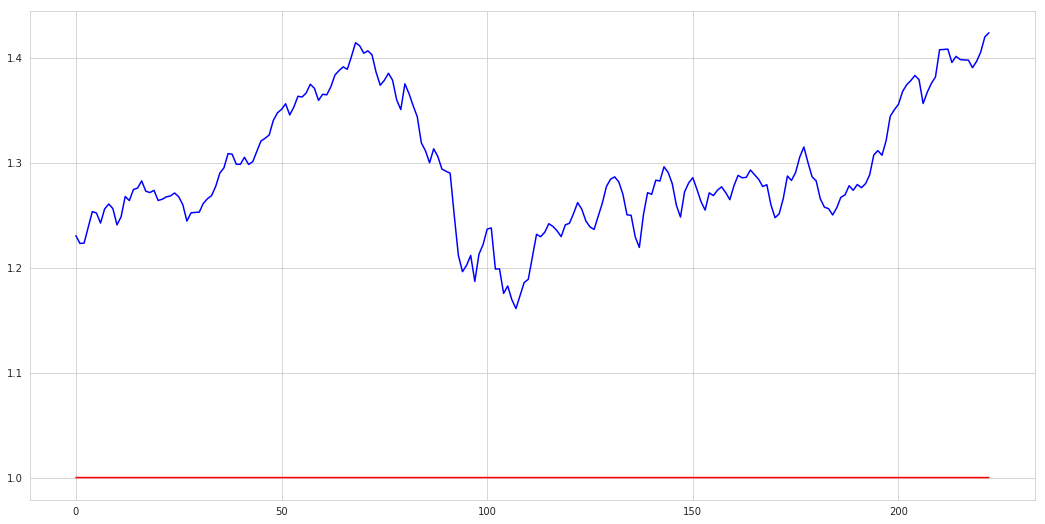

In [92]:
plt.figure(figsize = (18,9))
plt.plot(np.arange(len(y_test)), y_test, color='blue')
plt.plot(np.arange(len(y_test)), prediction2, color='red')

In [ ]:
X_train.shape